# Car classifier

This notebook trains a classifier to identify images of cars

## Prepare training and test data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Function to download files
from  urllib.request import urlretrieve
import os.path
from zipfile import ZipFile
import fnmatch
import matplotlib.image as mpimg

def download_file(url, local_path):
    if os.path.exists(local_path):
        print('{0} already downloaded'.format(local_path))
    else:
        urlretrieve(url, local_path)
        print('{0} downloaded'.format(local_path))
        
# Function to read from zip archives
def read_file(local_path):
    images = []
    with ZipFile(local_path, 'r') as archive:
        file_names = fnmatch.filter(archive.namelist(), '*.png')
        # Remove hidden files
        file_names = [f for f in file_names if '/.' not in f]
        for f in file_names:
            images.append(mpimg.imread(archive.open(f)))
    return images

In [3]:
# Download training data
download_file('https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip', 'data/vehicles.zip')
download_file('https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip', 'data/non-vehicles.zip')

data/vehicles.zip already downloaded
data/non-vehicles.zip already downloaded


In [4]:
vehicles = read_file('data/vehicles.zip')
non_vehicles = read_file('data/non-vehicles.zip')
print('Loaded {0} vehicle images'.format(len(vehicles)))
print('Loaded {0} non-vehicle images'.format(len(non_vehicles)))

Loaded 8792 vehicle images
Loaded 8968 non-vehicle images


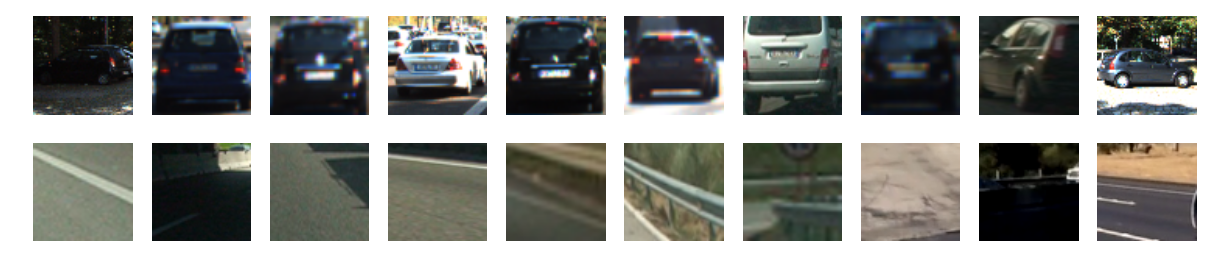

In [5]:
# Plot a selection of images
fig = plt.figure(figsize=(15, 3))
for idx in range(10):
    ax = fig.add_subplot(2, 10, idx + 1)
    ax.imshow(vehicles[np.random.randint(len(vehicles))])
    ax.set_axis_off()
for idx in range(10):
    ax = fig.add_subplot(2, 10, idx + 10 + 1)
    ax.imshow(non_vehicles[np.random.randint(len(non_vehicles))])
    ax.set_axis_off()

In [6]:
# Label and then shuffle
from sklearn.utils import shuffle
y = np.vstack([np.ones((len(vehicles), 1)), np.zeros((len(non_vehicles), 1))])
X = np.vstack([vehicles, non_vehicles])
X, y = shuffle(X, y, random_state=0)

In [7]:
# Split training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Build features

In [8]:
from features import extract_features

## Train SVM classifier

In [9]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import time

In [10]:
# Parameters
parameters = {'spatial': 32,
              'histbin': 64,
              'color_space': 'YCRCB',
              'hog_channel': 'ALL'}

# Extract features and create scaler
X_train_f = extract_features(X_train, 
                             color_space=parameters['color_space'], 
                             spatial_size=(parameters['spatial'], parameters['spatial']),
                             hist_bins=parameters['histbin'], 
                             orient=9, pix_per_cell=8, cell_per_block=2, 
                             hog_channel=parameters['hog_channel'],
                             spatial_feat=True, hist_feat=True, hog_feat=True)
X_test_f  = extract_features(X_test, 
                             color_space=parameters['color_space'], 
                             spatial_size=(parameters['spatial'], parameters['spatial']),
                             hist_bins=parameters['histbin'], 
                             orient=9, pix_per_cell=8, cell_per_block=2, 
                             hog_channel=parameters['hog_channel'],
                             spatial_feat=True, hist_feat=True, hog_feat=True)
scaler = StandardScaler()
scaler.fit(X_train_f)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
svc = LinearSVC()
t0 = time.time()
svc.fit(scaler.transform(X_train_f), y_train.ravel())
print('{0} s  to fit SVC'.format(round(time.time() - t0, 2)))

9.27 s  to fit SVC


In [12]:
print('Train Accuracy of SVC = ', round(svc.score(scaler.transform(X_train_f), y_train.ravel()), 4))
print('Test Accuracy of SVC = ', round(svc.score(scaler.transform(X_test_f), y_test.ravel()), 4))

Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9887


## Prediction

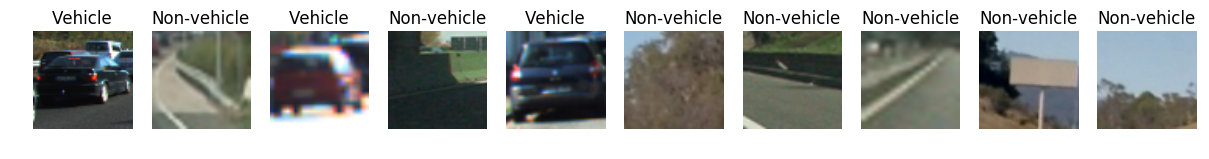

In [13]:
# Predict using first 10 test images
pred = svc.predict(scaler.transform(X_test_f[:10]))
fig = plt.figure(figsize=(15, 2))
for idx, prediction in enumerate(pred):
    ax = fig.add_subplot(1, 10, idx + 1)
    ax.imshow(X_test[idx])
    ax.set_axis_off()
    ax.set_title('Vehicle' if prediction > 0.5 else 'Non-vehicle')
    
fig.savefig('output_images/classifier.png')

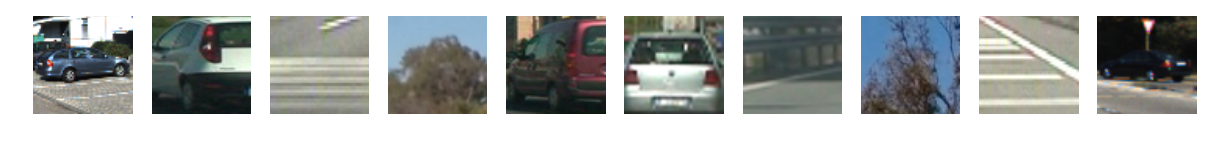

In [14]:
# Display some mis-classified images
pred = svc.predict(scaler.transform(X_test_f))
mis_classified = X_test[pred != y_test.ravel()]
fig = plt.figure(figsize=(15, 2))
for idx, img in enumerate(mis_classified[:10]):
    ax = fig.add_subplot(1, 10, idx + 1)
    ax.imshow(img)
    ax.set_axis_off()

## Save objects

In [15]:
import pickle
with open('classifier.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    pickle.dump(svc, f)
    pickle.dump(parameters, f)